# **Pulsar Star Project**

### Group 144

Authors:
* Chadd Hennig, 37879814
* Jenni Tong, 23988835
* Jincheng Hong, 16879926
* Susan Liu, 25691544




## Introduction

Pulsar detection is a significant endeavour within astrophysics, as it provides scientists with a deeper understanding of the cosmos. Specifically, the discovery of pulsars provide information about certain timelines in the universe, as well as information about the inter-stellar medium itself. Pulsars are the remains of a collapsed star— also known as neutron stars. Such neutron stars produce radio emissions, which lies as the basis for pulsar discovery. Pulsar rotation results in a distinct radio emission pattern, which instruments on earth can then detect to confirm the pulsar’s existence. The issue, however, is that there are various celestial objects that produce detectable radio emissions.

Therefore, this project analyzes the question of classifying whether or not certain emission patterns are actually from pulsars.  

To approach this, this project used HTRU2 data set to predict which pulsar candidates are truly pulsars.

## Methods & Results

#describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.

First find out variables that have strong relationships with pulsar star, choose as predictors.

Steps: 

1. Create Recipe  
    Create a recipe with `class` ~ predictors above.  
   Use `step_scale()` and `step_center()` to scale and centre the 5 variables.

    
2. Cross-Validate the data  
    Use the training data to create a k-nearest-neighbor model that performs a 5-fold cross-validation.
    
    
3. Workflow to get ideal *K*  
    Create a workflow and fit the 5-fold data in to choose an ideal *K*.

4. Workflow and Fit  
   Create a workflow to fit all training data.
    
5. Use our classifier to predict the testing data `pulsar_test`

6. Evaluate our model  
   Create a table to show the accuracy of our model using the `metrics()`, then compare.
    

### 1. Loads Data

In [1]:
install.packages("themis")

also installing the dependencies ‘RANN’, ‘ROSE’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



In [52]:
#load library
library(tidyverse)
library(repr)
library(digest)
library(cowplot)
library(tidymodels)

library(themis)

In [3]:
# Read in the data set
pulsar <- read_csv('https://raw.githubusercontent.com/susanyliu/dsci100-project144/main/data/HTRU_2.csv', col_names = FALSE)

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


### 2. Cleaning and Wrangling

In [4]:
# Add column names
colnames(pulsar) <- c('Profile_mean', 'Profile_stdev', 'Profile_skewness', 'Profile_kurtosis', 
                      'DM_mean', 'DM_stdev', 'DM_skewness', 'DM_kurtosis', 'class')

In [5]:
# Changed the column "Class" into factor
pulsar_class <- pulsar |>
    pull(class)

pulsar <-  pulsar |>
    mutate(class = ifelse(pulsar_class, "Pulsar", "Non_Pulsar")) |>
    mutate(class = as_factor(class))

In [6]:
#set seed
set.seed(144)

# split data into 75% training and 25% testing
pulsar_split <- initial_split(pulsar, prop = 0.75, strata = class)
pulsar_train <- training(pulsar_split)
pulsar_test <- testing(pulsar_split)

In [7]:
#print the first 5 observations of the pulsar data
head(pulsar, n = 5)

Profile_mean,Profile_stdev,Profile_skewness,Profile_kurtosis,DM_mean,DM_stdev,DM_skewness,DM_kurtosis,class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,Non_Pulsar
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,Non_Pulsar
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,Non_Pulsar
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,Non_Pulsar
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,Non_Pulsar


### 3. Summarize the Data

To have a overview of our data(training data), we  
1. summarized the mean value for each predictor  
2. counted the number of observations for each class.  

Note: there is no missing values.

In [8]:
#summarize and create a table
predictor_mean <- pulsar_train |>
    group_by(class) |>
    summarize(Profile_mean = mean(Profile_mean) , Profile_stdev = mean(Profile_stdev),
              Profile_skewness = mean(Profile_skewness),Profile_kurtosis = mean(Profile_kurtosis),
              DM_mean = mean(DM_mean),n=n())

Now take a look at our summarized table.  
Here, columns 2-6 represent the mean value of that variable 
(e.g. the data column `Profile_stdev` represent the mean value of Profile standard deviation of Non Pulsar Stars and Pulsar Stars).  
Column `n` represents the number of observations in that class.

In [9]:
paste("table 1")
predictor_mean

[1] "table 1"

class,Profile_mean,Profile_stdev,Profile_skewness,Profile_kurtosis,DM_mean,n
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>
Non_Pulsar,116.56174,47.32295,0.2111174,0.378781,8.722467,12235
Pulsar,56.93468,38.70407,3.1311589,15.618123,50.268911,1188


### 4. Visualize the Data

To find which variables are relevant to distinguish a pulsar star, we created several scatter plots between variables and colored according to their classes.

In [29]:
#plot to see related variables
plot1.2 <- pulsar_train|>
    ggplot(aes(x = Profile_mean, y= Profile_stdev, color = class))+
    geom_point(alpha = 0.6)+
    labs(x = 'Mean of the integrated profile', y = 'Standard deviation of the integrated profile', color = "Is pulsar?")

plot1.3 <- pulsar_train|>
    ggplot(aes(x = Profile_mean, y= Profile_skewness, color = class))+
    geom_point(alpha = 0.6)+
    labs(x = 'Mean of the integrated profile', y = 'Excess kurtosis of the integrated profile', color = "Is pulsar?")

plot1.4 <- pulsar_train|>
    ggplot(aes(x = Profile_mean, y= Profile_skewness, color = class))+
    geom_point(alpha = 0.6)+
    labs(x = 'Mean of the integrated profile', y = 'Skewness of the integrated profile', color = "Is pulsar?")

plot2.3 <- pulsar_train|>
    ggplot(aes(x = Profile_stdev, y= Profile_skewness, color = class))+
    geom_point(alpha = 0.6)+
    labs(x = 'Standard deviation of the integrated profile', y = 'Excess kurtosis of the integrated profile', color = "Is pulsar?")

plot2.4 <- pulsar_train|>
    ggplot(aes(x = Profile_stdev, y= Profile_kurtosis, color = class))+
    geom_point(alpha = 0.6)+
    labs(x = 'Standard deviation of the integrated profile', y = 'Skewness of the integrated profile', color = "Is pulsar?")

plot2.5 <- pulsar_train|>
    ggplot(aes(x = Profile_stdev, y= DM_mean, color = class))+
    geom_point(alpha = 0.6)+
    labs(x = 'Standard deviation of the integrated profile', y = 'Mean of the DM-SNR curve', color = "Is pulsar?")

plot3.4 <- pulsar_train|>
    ggplot(aes(x = Profile_skewness, y = Profile_kurtosis, color = class))+
    geom_point(alpha = 0.6)+
    labs(x = 'Excess kurtosis of the integrated profile', y = 'Skewness of the integrated profile', color = "Is pulsar?")

plot3.5 <- pulsar_train|>
    ggplot(aes(x = Profile_skewness, y= DM_mean, color = class))+
    geom_point(alpha = 0.6)+
    labs(x = 'Excess kurtosis of the integrated profile', y = 'Mean of the DM-SNR curve', color = "Is pulsar?")

plot4.5 <- pulsar_train|>
    ggplot(aes(x = Profile_kurtosis, y = DM_mean, color = class))+
    geom_point(alpha = 0.6)+
    labs(x = 'Skewness of the integrated profile', y = 'Mean of the DM-SNR curve', color = "Is pulsar?")

plot5.6 <- pulsar_train|>
    ggplot(aes(x = DM_mean, y= DM_stdev, color = class))+
    geom_point(alpha = 0.6)+
    labs(x = 'Mean of the DM-SNR curve', y = 'Standard deviation of the DM-SNR curve', color = "Is pulsar?")

plot6.7 <- pulsar_train|>
    ggplot(aes(x = DM_stdev, y= DM_skewness, color = class))+
    geom_point(alpha = 0.6)+
    labs(x = 'Standard deviation of the DM-SNR curve', y = 'Excess kurtosis of the DM-SNR curve', color = "Is pulsar?")

plot7.8 <- pulsar_train|>
    ggplot(aes(x = DM_skewness, y= DM_kurtosis, color = class))+
    geom_point(alpha = 0.6)+
    labs(x = 'Excess kurtosis of the DM-SNR curve', y = 'Skewness of the DM-SNR curve', color = "Is pulsar?")

We analyzed the plots above and found that: pulsar stars tend to have **low** mean of the integrated profile, **high** excess kurtosis of the integrated profile, and **high** skewness of the integrated profile.

Below are plots showing these relationships.

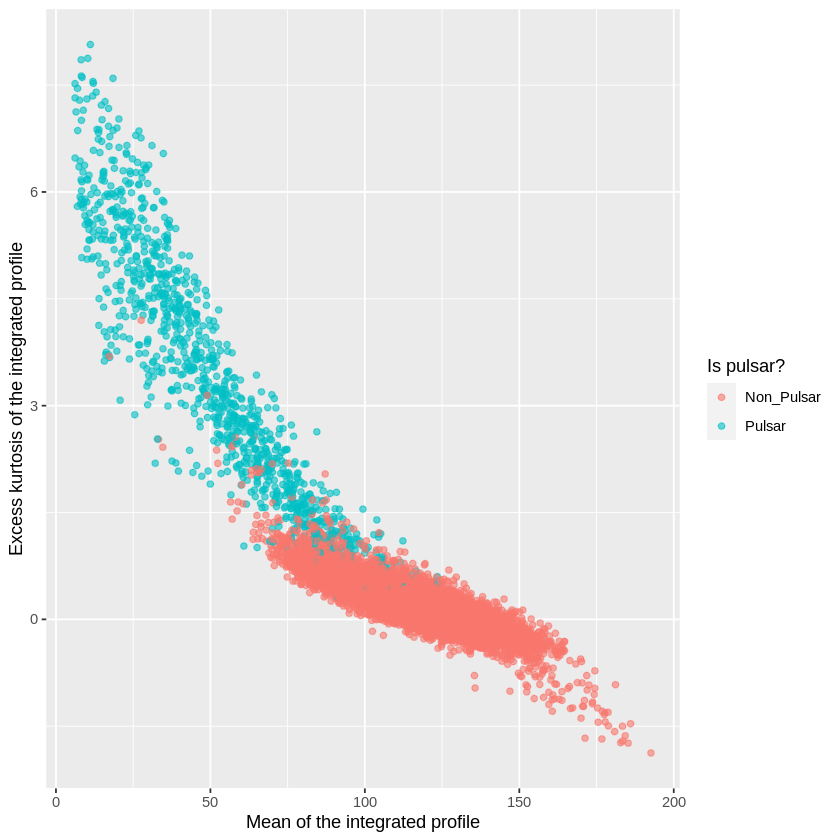

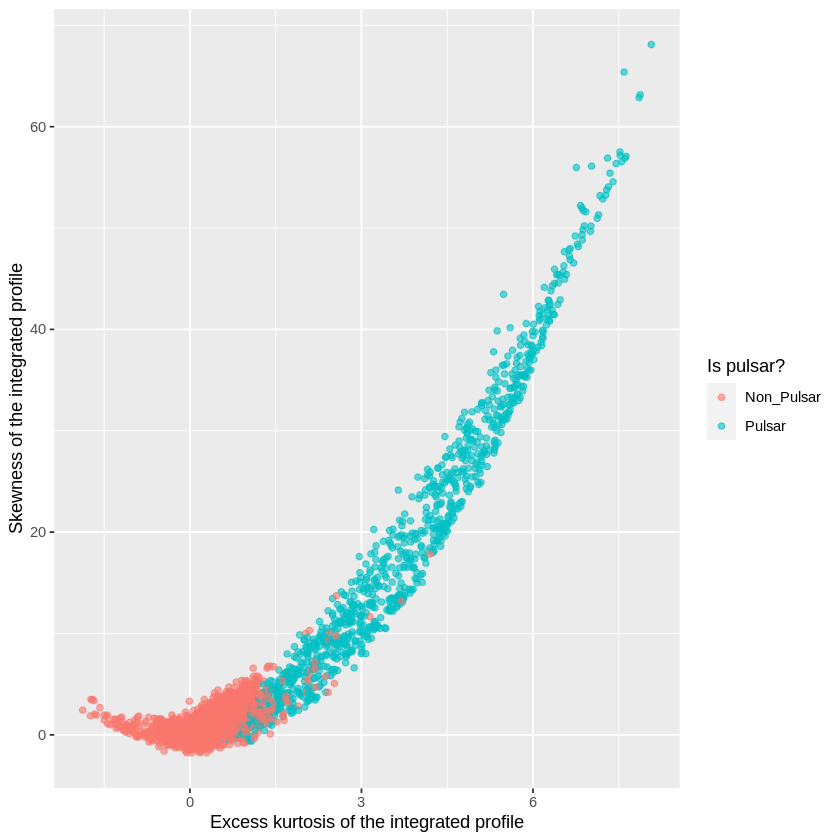

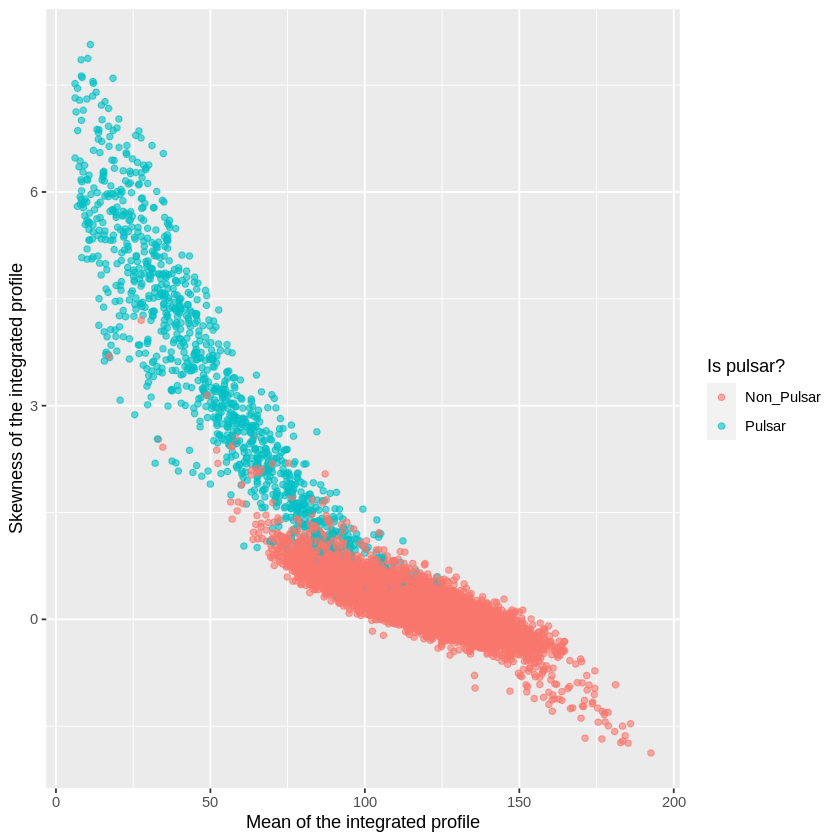

In [30]:
plot1.3
plot3.4
plot1.4

Therefore, we chose `Profile_mean`, `Profile_skewness`, `Profile_kurtosis` as predictors.

### 5. Perform the data analysis using $k$-nn

In [31]:
set.seed(144)

# creat "up_sample" recipe 
pulsar_wee <- recipe(class ~ Profile_mean + Profile_skewness + 
                        Profile_kurtosis, data = pulsar_train) |>
     step_upsample(class, over_ratio = 1, skip = FALSE) |>
     prep() |>
     bake(pulsar_train)

pulsar_recipe <- recipe(class ~ Profile_mean + Profile_skewness + 
                        Profile_kurtosis, data = pulsar_wee) |>
     step_scale(all_predictors()) |>
     step_center(all_predictors())

In [32]:
set.seed(144)

# cross-validate
pulsar_vfold <- vfold_cv(pulsar_train, v = 5, strata = class)

In [33]:
set.seed(144)

# creat model
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
     set_engine("kknn") |>
     set_mode("classification")

In [35]:
set.seed(144)

k_vals = tibble(neighbors = seq(from = 1, to = 10, by = 1))

# tune grid
knn_results <- workflow() |>
     add_recipe(pulsar_recipe) |>
     add_model(knn_spec) |>
     tune_grid(resamples = pulsar_vfold, grid = k_vals) |>
     collect_metrics()

In [36]:
# find accuraties
accuracies <- knn_results |>
     filter(.metric == "accuracy")

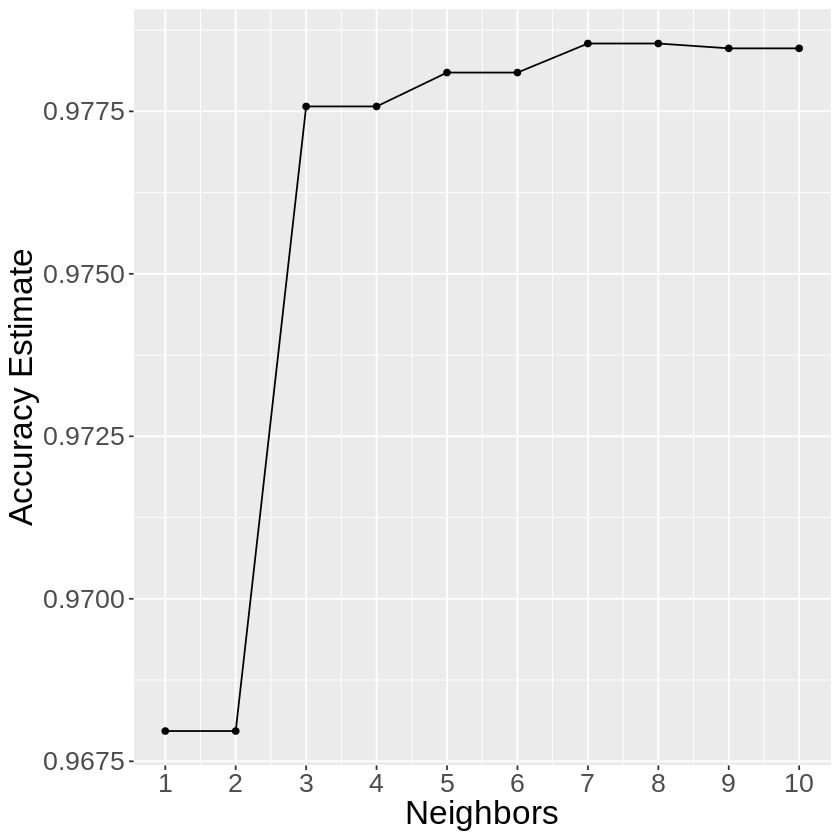

In [38]:
# plot to find best k
cross_val_plot <- accuracies |>
       ggplot(aes(x = neighbors, y = mean)) +
       geom_point() +
       geom_line() +
       scale_x_continuous(breaks = 1:10) +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       theme(text = element_text(size = 20))

cross_val_plot

We chose $k = 7$ because it has the best estimated accuracy.

In [40]:
set.seed(144)

# creat model using the best k
pulsar_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) |>
       set_engine("kknn") |>
       set_mode("classification")

# fit with the training data
pulsar_fit <- workflow() |>
       add_recipe(pulsar_recipe) |>
       add_model(pulsar_spec) |>
       fit(data = pulsar_train)

In [47]:
# predict the testing data
pulsar_predictions <- predict(pulsar_fit, pulsar_test) |>
          bind_cols(pulsar_test)

pulsar_metrics <- pulsar_predictions |>
          metrics(truth = class, estimate = .pred_class)     

pulsar_conf_mat <- pulsar_predictions|>
          conf_mat(truth = class, estimate = .pred_class)


pulsar_metrics
pulsar_conf_mat
# pulsar_predictions

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.9787709
kap,binary,0.8774454


            Truth
Prediction   Non_Pulsar Pulsar
  Non_Pulsar       3999     70
  Pulsar             25    381

The model does a really good job since it has an accuracie of 97.9%. However, the high accuracie may because the data is unbalanced: non pulsar stars are way more than pulsar stars; even if the machine predicts every star to be non pulsar, it would have 90% accuracy. But since we have upsampled the training data, it is better trained. If having a closer look at pulsar stars, 84.5% were predicted correctly as pulsars and 15.4% were as non pulsars.

### 6. Visualization of the Analysis

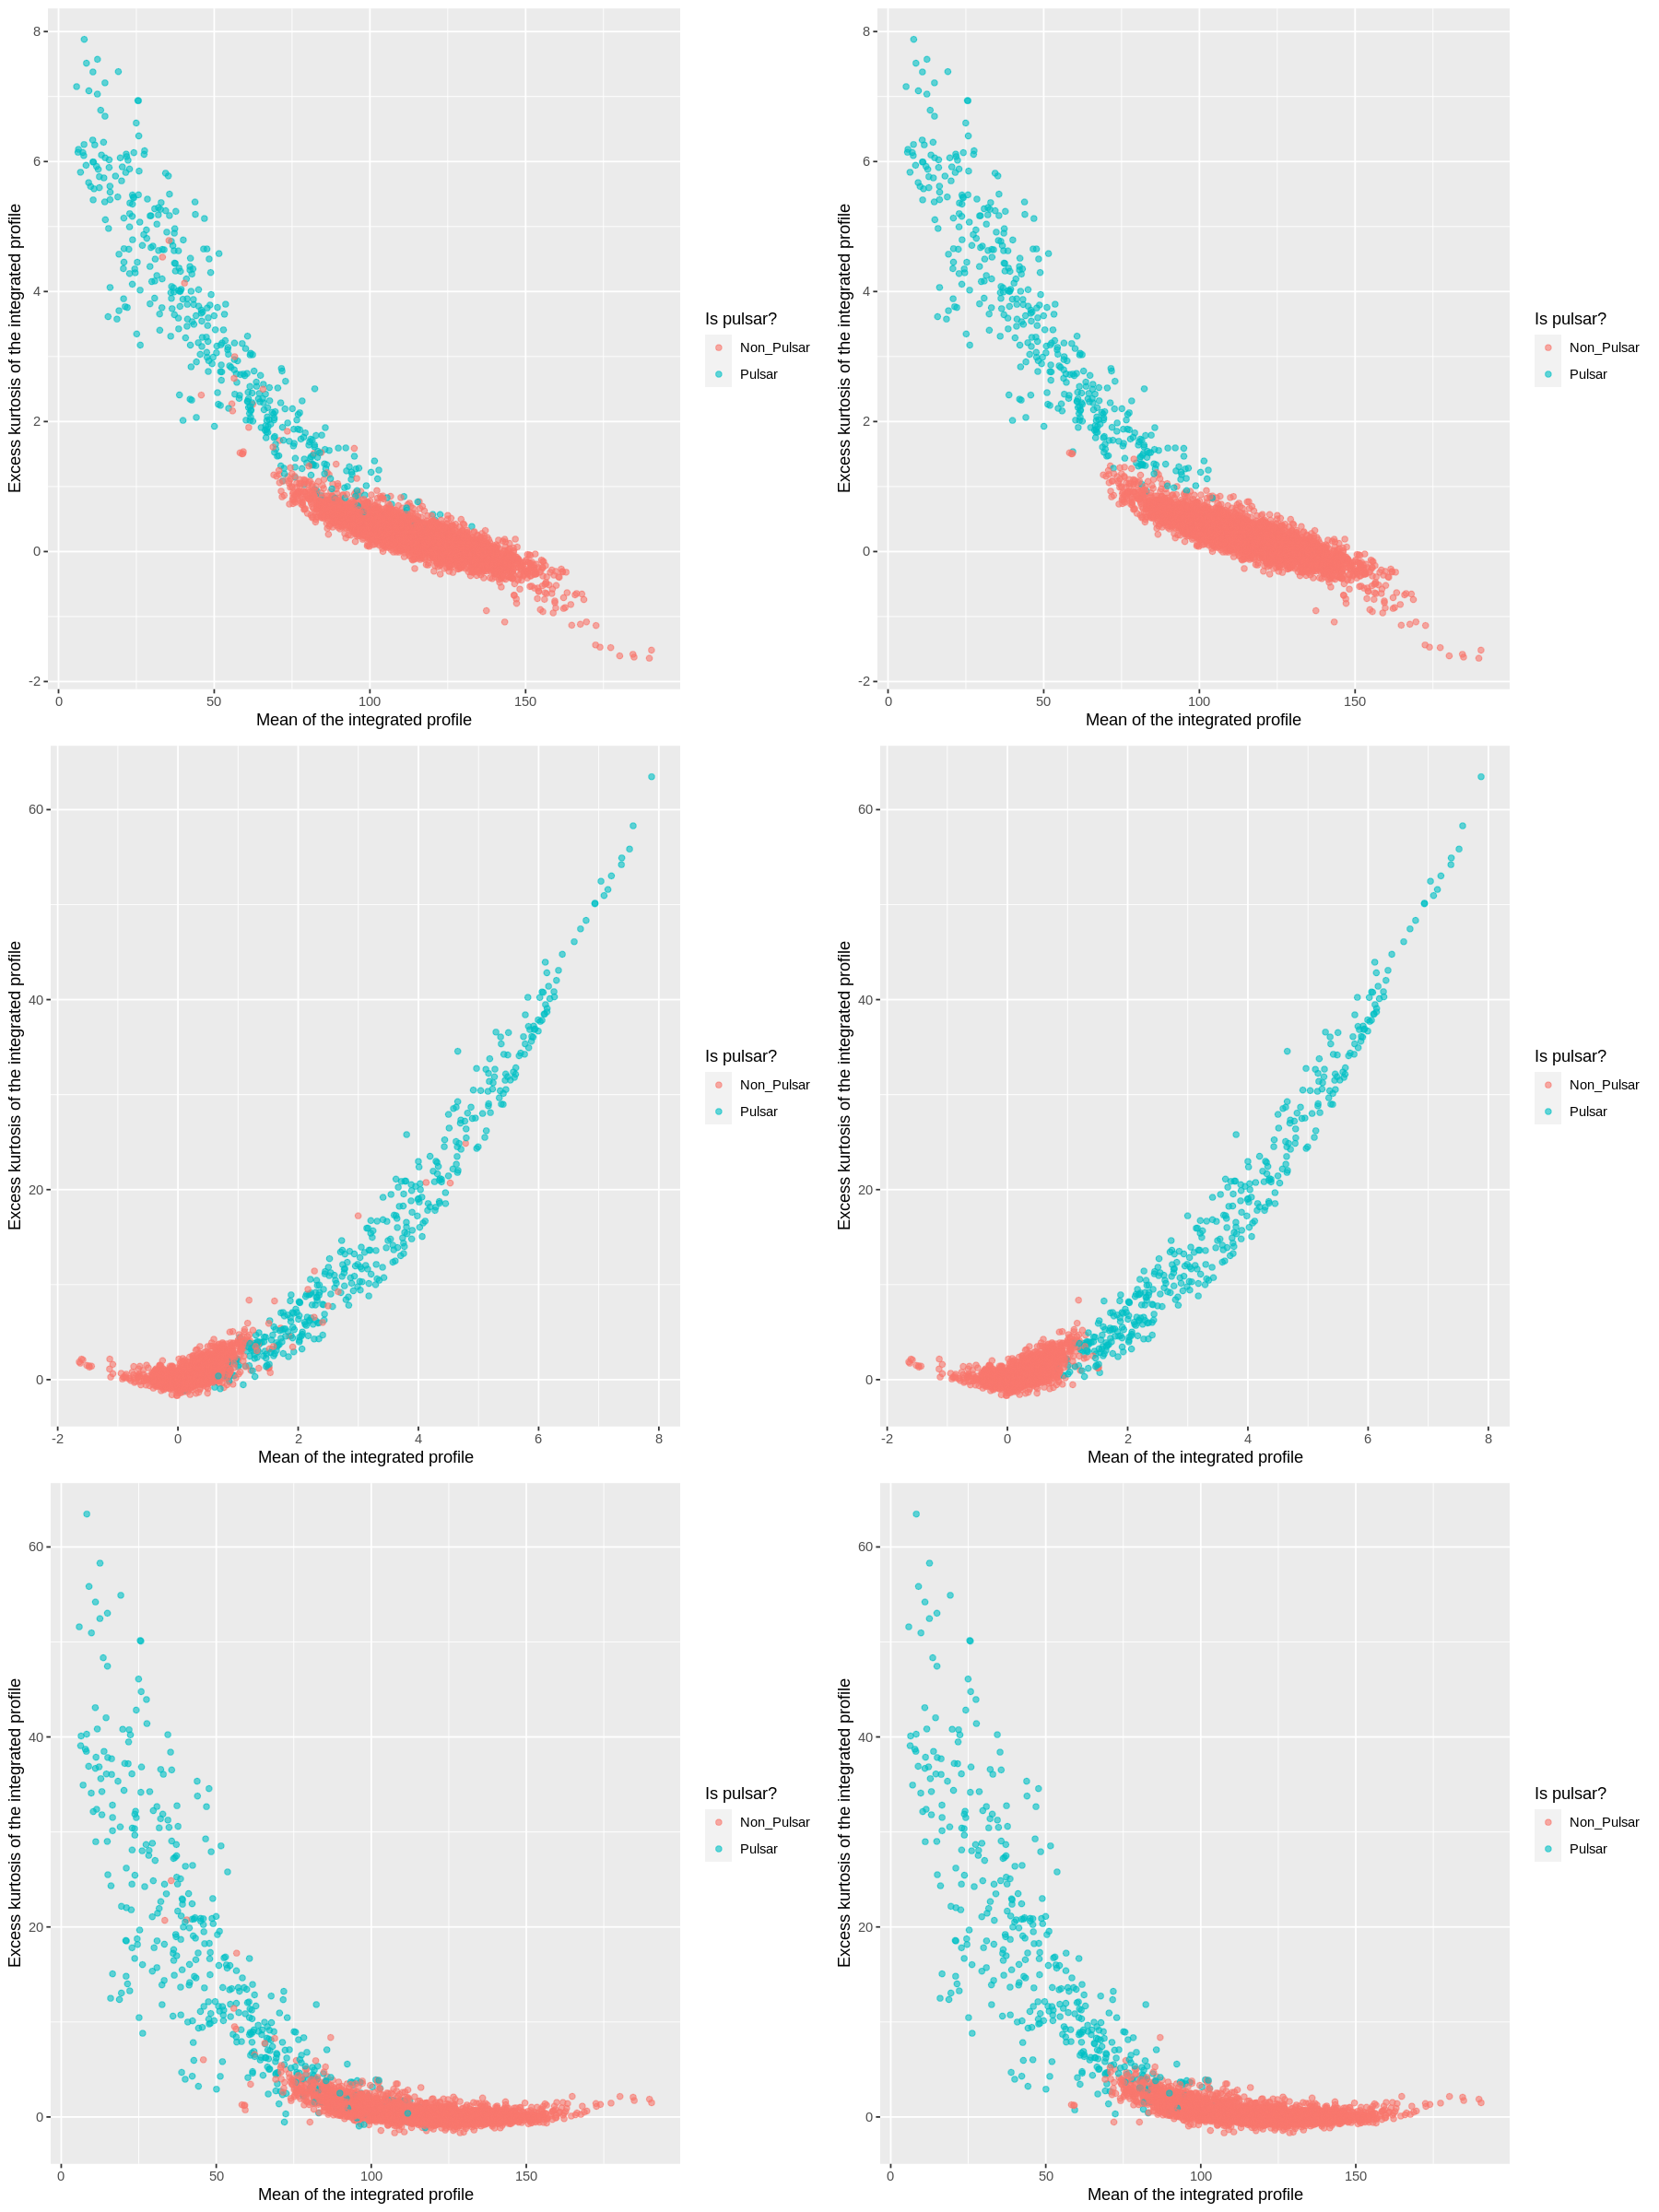

In [61]:
testplot1.3 <- pulsar_predictions |>
    ggplot(aes(x = Profile_mean, y= Profile_skewness, color = class))+
    geom_point(alpha = 0.6)+
    labs(x = 'Mean of the integrated profile', y = 'Excess kurtosis of the integrated profile', color = "Is pulsar?")

testplot1.3_pred <- pulsar_predictions |>
    ggplot(aes(x = Profile_mean, y= Profile_skewness, color = .pred_class))+
    geom_point(alpha = 0.6)+
    labs(x = 'Mean of the integrated profile', y = 'Excess kurtosis of the integrated profile', color = "Is pulsar?")

testplot3.4 <- pulsar_predictions |>
    ggplot(aes(x = Profile_skewness, y= Profile_kurtosis, color = class))+
    geom_point(alpha = 0.6)+
    labs(x = 'Mean of the integrated profile', y = 'Excess kurtosis of the integrated profile', color = "Is pulsar?")

testplot3.4_pred <- pulsar_predictions |>
    ggplot(aes(x = Profile_skewness, y= Profile_kurtosis, color = .pred_class))+
    geom_point(alpha = 0.6)+
    labs(x = 'Mean of the integrated profile', y = 'Excess kurtosis of the integrated profile', color = "Is pulsar?")

testplot1.4 <- pulsar_predictions |>
    ggplot(aes(x = Profile_mean, y= Profile_kurtosis, color = class))+
    geom_point(alpha = 0.6)+
    labs(x = 'Mean of the integrated profile', y = 'Excess kurtosis of the integrated profile', color = "Is pulsar?")

testplot1.4_pred <- pulsar_predictions |>
    ggplot(aes(x = Profile_mean, y= Profile_kurtosis, color = .pred_class))+
    geom_point(alpha = 0.6)+
    labs(x = 'Mean of the integrated profile', y = 'Excess kurtosis of the integrated profile', color = "Is pulsar?")

options(repr.plot.width = 15, repr.plot.height = 20)
plot_grid(testplot1.3, testplot1.3_pred,
          testplot3.4, testplot3.4_pred,
          testplot1.4, testplot1.4_pred, ncol = 2)

From the plots, it can be seen that the model is overall good, but do well on "outliers" for each class (e.g., pulsar stars that fall in the area of non pulsar stars are predicted as non pulsar).

## Discussion

The classification of these candidates will provide a glimpse into the reality of pulsar existence, and more precisely pulsar abundance. We will be able to identify what proportion of these candidates are actually pulsars. We predict that there will be more candidates that aren't pulsars than those that are. This is due to the overwhelming number of interstellar objects which release radio emissions.  



Regardless of what the data proves to be true, the significance of the outcome will be crucial in making further progress in the astrophysics field. Once candidates are classified as pulsars, scientists can hone in on these samples and learn more about their origins and behaviour — providing information about stellar collapse and even about planets beyond the solar system we live in.  

With this information, further research may address certain questions regarding pulsars. Questions may include: what relationship exists between pulsar existence and extraterrestrial life? What factors most accurately indicate between pulsars and non-pulsars? Ultimately, the findings of this data classification will be significant in the realm of astrophysics.

## References

Cofield, C. (2016, April 22). What are pulsars? Space.com. Retrieved November 28, 2022, from https://www.space.com/32661-pulsars.html

HTRU2 Data Set. UCI Machine Learning Repository: HTRU2 data set. (n.d.). Retrieved November 28, 2022, from https://archive.ics.uci.edu/ml/datasets/HTRU2

Pulsars astronomy. National Radio Astronomy Observatory. (2022, January 25). Retrieved November 28, 2022, from https://public.nrao.edu/radio-astronomy/pulsars/ 

R. J. Lyon, B. W. Stappers, S. Cooper, J. M. Brooke, J. D. Knowles, Fifty Years of Pulsar Candidate Selection: From simple filters to a new principled real-time classification approach, Monthly Notices of the Royal Astronomical Society 459 (1), 1104-1123, DOI: 10.1093/mnras/stw656 

Zhang, C. J., Shang, Z. H., Chen, W. M., Xie, L., & Miao, X. H. (2020). A review of Research on Pulsar candidate recognition based on machine learning. Procedia Computer Science, 166, 534–538. https://doi.org/10.1016/j.procs.2020.02.050
